In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Basic Data and EDA

In [2]:
data=pd.read_csv(r"C:\Users\hp\Desktop\internship\ml webapp\reviews_badminton\data.csv")
data.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [4]:
data.loc[0,"Review text"]

'Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.READ MORE'

In [5]:
df=data[['Review text','Ratings']]
df.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [6]:
df.Ratings.value_counts()

Ratings
5    5080
4    1746
1     769
3     615
2     308
Name: count, dtype: int64

In [7]:
df['Ratings']=[ 'Negative Review' if 1 <= i < 4  else 'Positive Review'  for i in df['Ratings']]

In [8]:
df["Ratings"].value_counts()

Ratings
Positive Review    6826
Negative Review    1692
Name: count, dtype: int64

In [9]:
df["Review text"].isnull().sum()

8

In [10]:
df["Review text"]=df["Review text"].apply(lambda x: str(x))

In [11]:
df.dropna(axis=0,inplace=True)
df["Review text"].isnull().sum()

0

In [12]:
df.to_csv(r"C:\Users\hp\Desktop\internship\mlops\sentimental_analysis_orches\data\yonex_data.csv",index=False)
df.shape

(8518, 2)

## Defining Input and Output features and Splitting the data

In [14]:
x=df["Review text"]
y=df["Ratings"]


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2)

print("x_train:",x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

x_train: (6814,)
x_test: (1704,)
y_train: (6814,)
y_test: (1704,)


In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(data):
    wc=WordCloud(background_color='white', width=1600,height=1800).generate(''.join(data))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

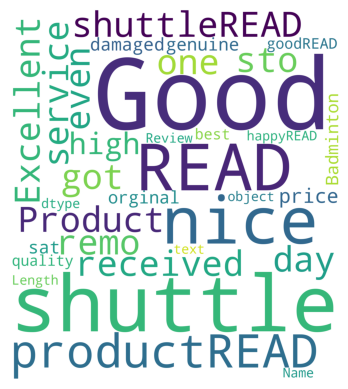

In [16]:
wordcloud(str(x_train))

## Data Preprocessing

In [17]:
import nltk
from textblob import TextBlob,Word
from nltk.corpus import stopwords
sw=stopwords.words("english")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lematizer=WordNetLemmatizer()
import string


def clean(text):
    #checking punctuation and removing numbers
    text="".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    #converting lower case
    text=text.lower()
    #tokenization
    tokens=nltk.word_tokenize(text)
    #lematization
    lematized_tokens=[lematizer.lemmatize(token) for token in tokens]
    #removeing stopwords
    filtered_tokens=[word for word in lematized_tokens if word.lower() not in sw]
    
    #join and return
    return " ".join(filtered_tokens)

## Creating an Optimal Workflow with ML Flow

In [22]:
import mlflow

mlflow.set_experiment("Sentimental_analysis_yonex")

<Experiment: artifact_location='file:///c:/Users/hp/Desktop/internship/mlops/sentimental_analysis_mlflow/mlruns/695204522398013242', creation_time=1711382755679, experiment_id='695204522398013242', last_update_time=1711382755679, lifecycle_stage='active', name='Sentimental_analysis_yonex', tags={}>

In [23]:
import joblib
from joblib import Memory

import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [24]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer(preprocessor=clean)),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer(preprocessor=clean)),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer(preprocessor=clean)),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
             'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

In [25]:
best_models = {}

# Run the Pipeline
for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='accuracy', 
                               return_train_score=True,
                               verbose=1
                              )
    
    mlflow.sklearn.autolog(max_tuning_runs=None)
    
    with mlflow.start_run() as run:
        %time grid_search.fit(x_train, y_train)
        
    print('Train Score: ', grid_search.best_score_)
    print('Test Score: ', grid_search.score(x_test, y_test))
    
    best_models[algo] = grid_search.best_estimator_
    print()

********** naive_bayes **********


2024/03/28 12:43:41 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/03/28 12:43:41 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 5.66 s
Wall time: 25.3 s
Train Score:  0.8830367925981708
Test Score:  0.8779342723004695

********** decision_tree **********


2024/03/28 12:44:07 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 17 s
Wall time: 46.3 s
Train Score:  0.886851798582853
Test Score:  0.8820422535211268

********** logistic_regression **********


2024/03/28 12:44:54 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

### Saved the best models using MLFLOW UI

In [34]:
#stopped the auto log of mlflow
mlflow.sklearn.autolog(disable=True)